In [2]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [3]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [4]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape

24009it [01:58, 203.05it/s]
3047it [00:14, 208.20it/s]
2988it [00:13, 214.14it/s]


In [5]:
X_autoencoder, Y_autoencoder, autoencoderFileList = bbdc.load_audioset("long_unbalanced_train_segments.csv", "unbalanced_fft_mel_l04_o02495_f32/", pathToDataDir="./../google_audioset/googleData/fft/")

16186it [08:27, 31.90it/s]


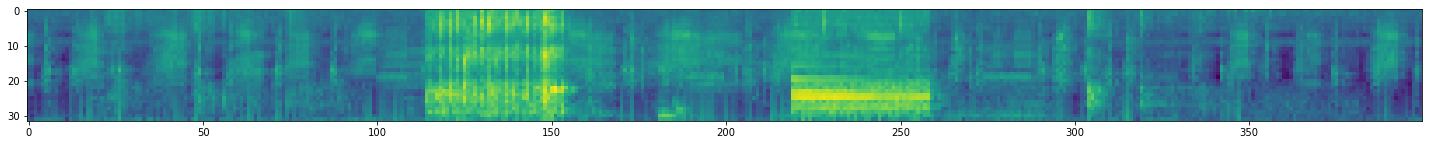

In [4]:
plt.figure(figsize=(25,5))
plt.imshow(np.rot90(X_train[0]))

In [40]:
X_challenge, _, timepoints, challengeFileList = bbdc.load_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
inputShape = X_challenge[0].shape

3000it [00:45, 66.27it/s]


In [ ]:
print(tf.__version__)
print(X_train.shape)

In [6]:
channels = [32, 64, 90]
model = unet.u_net(inputShape, channels, lessParameter = True)
autoencoder = keras.models.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 32)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 32)      1056        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 400, 32)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [7]:
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse', metrics=['mae', 'accuracy'])
history = autoencoder.fit(X_autoencoder,X_autoencoder, batch_size=15, epochs=100, shuffle=True)

Epoch 1/100
1080/1080 [==============================] - 61s 53ms/step - loss: 838.1622 - mae: 14.6651 - accuracy: 0.0299
Epoch 2/100
1080/1080 [==============================] - 57s 53ms/step - loss: 145.5737 - mae: 8.6217 - accuracy: 0.0617
Epoch 3/100
1080/1080 [==============================] - 57s 52ms/step - loss: 117.0595 - mae: 7.9136 - accuracy: 0.0645
Epoch 4/100
1080/1080 [==============================] - 80s 74ms/step - loss: 110.2171 - mae: 7.7484 - accuracy: 0.0685
Epoch 5/100
1080/1080 [==============================] - 70s 64ms/step - loss: 107.0323 - mae: 7.6371 - accuracy: 0.0856
Epoch 6/100
1080/1080 [==============================] - 63s 58ms/step - loss: 97.1091 - mae: 7.3198 - accuracy: 0.1233
Epoch 7/100
1080/1080 [==============================] - 63s 58ms/step - loss: 84.5194 - mae: 6.8527 - accuracy: 0.1588
Epoch 8/100
1080/1080 [==============================] - 63s 58ms/step - loss: 81.0409 - mae: 6.7178 - accuracy: 0.1771
Epoch 9/100
1080/1080 [===========

In [9]:
autoencoder.save("autoencoder.h5")

In [10]:
autoencoder.trainable = False
#for i in range(1,23):
#    autoencoder.layers[-i].trainable=True
x = layers.Conv1D(13, kernel_size=1, activation="softmax", padding="same")(autoencoder.layers[-1].output)
pretrainedModel = keras.models.Model(inputs=autoencoder.layers[0].input, outputs=x)
pretrainedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 32)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 32)      1056        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 400, 32)      0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [11]:
#Mit crossentropy
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
pretrainedModel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = pretrainedModel.fit(X_train,Y_train, batch_size=15, epochs=10, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/10
534/534 [==============================] - 12s 20ms/step - loss: 9.6740 - mae: 0.0958 - accuracy: 0.3895 - val_loss: 1.6377 - val_mae: 0.0777 - val_accuracy: 0.5925

Epoch 00001: val_loss improved from inf to 1.63771, saving model to model.h5
Epoch 2/10
534/534 [==============================] - 10s 18ms/step - loss: 1.4815 - mae: 0.0789 - accuracy: 0.6182 - val_loss: 1.3716 - val_mae: 0.0787 - val_accuracy: 0.6337

Epoch 00002: val_loss improved from 1.63771 to 1.37156, saving model to model.h5
Epoch 3/10
534/534 [==============================] - 10s 19ms/step - loss: 1.3355 - mae: 0.0783 - accuracy: 0.6440 - val_loss: 1.3207 - val_mae: 0.0772 - val_accuracy: 0.6454

Epoch 00003: val_loss improved from 1.37156 to 1.32066, saving model to model.h5
Epoch 4/10
534/534 [==============================] - 9s 17ms/step - loss: 1.2920 - mae: 0.0766 - accuracy: 0.6526 - val_loss: 1.2920 - val_mae: 0.0773 - val_accuracy: 0.6528

Epoch 00004: val_loss improved from 1.32066 to 1.29200

In [13]:
#Mit crossentropy
for i in range(1,23):
    autoencoder.layers[-i].trainable=True
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
pretrainedModel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = pretrainedModel.fit(X_train,Y_train, batch_size=15, epochs=100, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/100
534/534 [==============================] - 25s 41ms/step - loss: 0.9918 - mae: 0.0598 - accuracy: 0.7172 - val_loss: 0.9812 - val_mae: 0.0610 - val_accuracy: 0.7215

Epoch 00001: val_loss improved from inf to 0.98122, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 19s 36ms/step - loss: 0.9565 - mae: 0.0582 - accuracy: 0.7271 - val_loss: 0.9701 - val_mae: 0.0568 - val_accuracy: 0.7230

Epoch 00002: val_loss improved from 0.98122 to 0.97011, saving model to model.h5
Epoch 3/100
534/534 [==============================] - 19s 35ms/step - loss: 0.9367 - mae: 0.0573 - accuracy: 0.7317 - val_loss: 0.9620 - val_mae: 0.0581 - val_accuracy: 0.7242

Epoch 00003: val_loss improved from 0.97011 to 0.96200, saving model to model.h5
Epoch 4/100
534/534 [==============================] - 19s 35ms/step - loss: 0.9237 - mae: 0.0567 - accuracy: 0.7355 - val_loss: 0.9935 - val_mae: 0.0583 - val_accuracy: 0.7214

Epoch 00004: val_loss did not improve from 0.9620

In [17]:
autoencoder.trainable = True
opt = keras.optimizers.Adam(learning_rate=0.0005)
pretrainedModel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history2 = pretrainedModel.fit(X_train,Y_train, batch_size=15, epochs=20, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/20
534/534 [==============================] - 45s 76ms/step - loss: 1.0223 - mae: 0.0598 - accuracy: 0.7150 - val_loss: 0.7946 - val_mae: 0.0491 - val_accuracy: 0.7760

Epoch 00001: val_loss did not improve from 0.75939
Epoch 2/20
534/534 [==============================] - 40s 74ms/step - loss: 0.7310 - mae: 0.0466 - accuracy: 0.7898 - val_loss: 0.7212 - val_mae: 0.0443 - val_accuracy: 0.7946

Epoch 00002: val_loss improved from 0.75939 to 0.72123, saving model to model.h5
Epoch 3/20
534/534 [==============================] - 40s 74ms/step - loss: 0.6717 - mae: 0.0432 - accuracy: 0.8063 - val_loss: 0.6730 - val_mae: 0.0426 - val_accuracy: 0.8081

Epoch 00003: val_loss improved from 0.72123 to 0.67299, saving model to model.h5
Epoch 4/20
534/534 [==============================] - 42s 78ms/step - loss: 0.6410 - mae: 0.0415 - accuracy: 0.8156 - val_loss: 0.6459 - val_mae: 0.0422 - val_accuracy: 0.8148

Epoch 00004: val_loss improved from 0.67299 to 0.64588, saving model to model.h

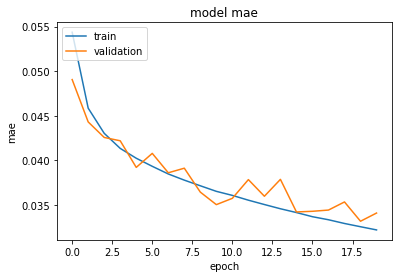

In [20]:
# summarize history for mae
plt.plot(history2.history['mae'])
plt.plot(history2.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

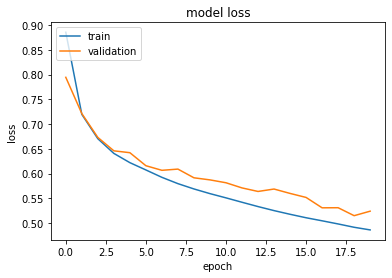

In [21]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

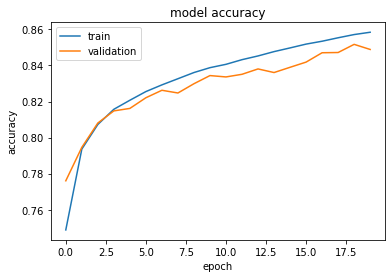

In [22]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
#model = keras.models.load_model("Modelle_Jannes/")
prediction = pretrainedModel.predict(X_test)

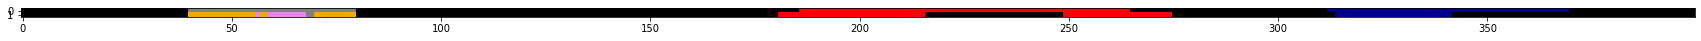

In [29]:
bbdc.plotPredictionAndGT(Y_test, prediction, 4)

In [30]:
scores = pretrainedModel.evaluate(X_test, Y_test)


32/32 [==============================] - 1s 36ms/step - loss: 0.5089 - mae: 0.0333 - accuracy: 0.8518


In [31]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/autoencoder_test.csv", index=False)
df.head()
evaluate.evaluate("../predictions/jannes/autoencoder_test.csv", "./../data/test.csv")

(0.0, 'Valid file')

In [32]:
postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/autoencoder_pp_test.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/autoencoder_pp_test.csv", "./../data/test.csv"))

(0.6954025364053913, 'Valid file')


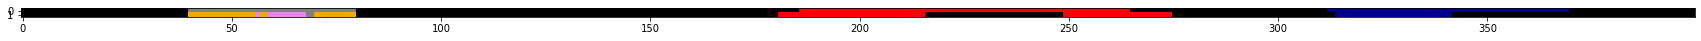

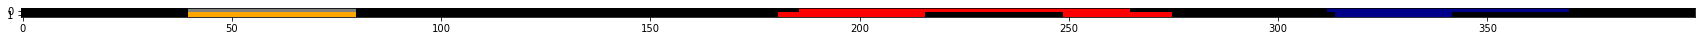

In [38]:
index = 4
bbdc.plotPredictionAndGT(Y_test, prediction, index) #TODO Problem mit falscher Farbdarstellung lösen
bbdc.plotPredictionAndGT(Y_test, postProcessedPrediction, index)

# Evaluation mit Validationset

In [25]:
prediction = model.predict(X_validation)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)
model.evaluate(X_validation, Y_validation)
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_val.csv", "./../data/validation.csv"))

postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_pp_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_pp_val.csv", "./../data/validation.csv"))

32/32 [==============================] - 0s 10ms/step - loss: 0.3118 - mae: 0.0179 - accuracy: 0.9119
(0.10671975887168393, 'Valid file')
(0.8564091127358349, 'Valid file')


# Prediction der Challenge

In [41]:
#model = keras.models.load_model("Modelle_Jannes/model9561.h5")
prediction = pretrainedModel.predict(X_challenge)
postProcessedPredictionChallenge = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPredictionChallenge, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/Autoencoder_Challenge.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
